<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_14_Calibration_using_Planar_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrinsic camera calibration using planar data

We will study how we can calibrate a camera's intrinsic parameters using points on a plane. As side information, we can also recover the geometry of the plane with respect to the camera. However, the recovery of the 3D geometry of the plane is secondary. The estimation of the intrinsic parameters will be important as it will transfer to other imaging scenarios with the same camera.

The approach we will study is commonly referred to as Zhang's calibration method. Although this particular approach became popular, others in the research community have also proposed using planes to calibrate a camera. Zhang made the procedure very easy to use by providing code and writing a paper that all can easily understand. This calibration approach is  also coded in OpenCV

Z. Zhang, "[A flexible new technique for camera calibration](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf)," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 22, no. 11, pp. 1330-1334, Nov. 2000, doi: 10.1109/34.888718.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/

Mounted at /content/drive
 0005_Walking001.xlsx			    left07.jpg
 0008_ChaCha001.xlsx			    left08.jpg
'Armes 1.png'				    left09.jpg
'Armes 2.png'				    left11.jpg
 blog_danforth_monica_mural_panorama.jpg    left12.jpg
 blog_monica_mural_brown_white.jpg	    lizard.jpg
 blog_monica_mural_fish_tree_windows1.jpg   MOT16-08-raw.webm
 hawaii.png				    mountain_peak_1.png
 house_1.png				    mountain_peak_2.png
 house_2.png				    parking_lot_meva_1.png
 house_facade.png			    parking_lot_meva_2.png
 left01.jpg				    parking_lot_meva_3.png
 left02.jpg				   'Superbowl 2021_1.png'
 left03.jpg				   'Superbowl 2021_2.png'
 left04.jpg				   'Superbowl 2021_3.png'
 left05.jpg				    window_1.png
 left06.jpg				    window_2.png


In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
from skimage.transform import warp
import torch.nn as nn
from skimage import io

!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)


np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

     |████████████████████████████████| 55.7MB 70kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
4.4.0


# Consider multiple images of the same plane

You can collect this using two ways: (i) keep the camera fixed and move the plane as is done in the images below, or (ii) move the camera with respect to a  fixed plane. The underlying geometry would be similar for both of these cases. We will build the recovery mathematics and algorithm for case (i), but it is also applicable for case (ii)

https://raw.githubusercontent.com/opencv/opencv/05b15943d6a42c99e5f921b7dbaa8323f3c042c6/samples/data/left01.jpg
https://raw.githubusercontent.com/opencv/opencv/05b15943d6a42c99e5f921b7dbaa8323f3c042c6/samples/data/left02.jpg
https://raw.githubusercontent.com/opencv/opencv/05b15943d6a42c99e5f921b7dbaa8323f3c042c6/samples/data/left03.jpg
https://raw.githubusercontent.com/opencv/opencv/05b15943d6a42c99e5f921b7dbaa8323f3c042c6/samples/data/left04.jpg


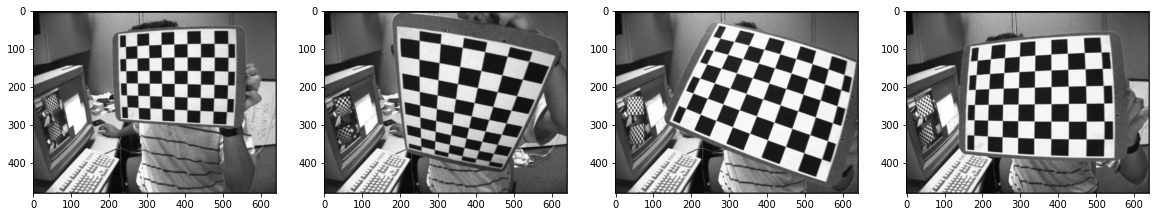

In [ ]:
calib_images = []
for i in range (4) :
    file_link = 'https://raw.githubusercontent.com/opencv/opencv/05b15943d6a42c99e5f921b7dbaa8323f3c042c6/samples/data/left{:02d}.jpg'.format(i+1)
    print(file_link)
    image = io.imread(file_link)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # change from scikit image to cv2 format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # change from color to gray
    calib_images.append(image)

plt.figure(figsize=(20,10))
for i in range (4) :
    plt.subplot(1,4,i+1)
    plt.imshow (calib_images[i], 'gray')


# Points on a 2D plane in 3D

Consider points on the plane $Z_p = 0$. The image points will be related to coordinates on the plane using a homography as follows.

\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} -\frac{f}{s_x} & 0 & c_x & 0\\ 0 & -\frac{f}{s_y} & c_y & 0\\ 0 & 0 & 1 & 0 \end{bmatrix}
    \begin{bmatrix} 
    r_{00} & r_{01} &  t_x \\ 
    r_{10} & r_{11} &  t_y \\
    r_{20} & r_{21} &  t_z \\
    0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ 1
    \end{bmatrix} \\
    & = &
    \begin{bmatrix} -\frac{f}{s_x} & 0 & c_x\\ 0 & -\frac{f}{s_y} & c_y \\ 0 & 0 & 1 \end{bmatrix}
    \begin{bmatrix} 
    r_{00} & r_{01} &  t_x \\ 
    r_{10} & r_{11} &  t_y \\
    r_{20} & r_{21} &  t_z 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}_c} & = & \mathbf{K} \mathbf{S}^{3 \times 3} \mathbf{\tilde{x}_p}\\
    & = &
    \begin{bmatrix} - & - & - &\\
    - & - & - &\\
    - & - & - &
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}_c} & = & \mathbf{H}^{3 \times 3} \mathbf{\tilde{x}_p}
\end{eqnarray}

Thus, points on a plane whose coordinates are specified with respect to the plane are related to the image points using a homography. 




# Relationship between homography, intrinsic, and partial extrinsic parameters

Given the correspondences between the points on the plane and the images, we can recover the homography between the image points and points on the plane, but only up to a scale, $\lambda$. 
The homography matrix is a product of two matrices: the intrinsic parameters and the reduced extrinsic parameters.

\begin{eqnarray}
 \mathbf{H_1} & = & \lambda \mathbf{K}\mathbf{S_1} 
 \end{eqnarray}

To estimate the $\mathbf{K}$ and $\mathbf{S_1}$, we follow a two-step process. First, we use the DLT method to form an initial estimate of the matrices. Second, we refine the estimates using a non-linear estimation based on image-based residuals.

# 1. DLT estimate

Multiplying both sides by the inverse of $\mathbf{K}$, we have

\begin{eqnarray}
 \mathbf{K}^{-1}\mathbf{H_1} & = & \lambda \mathbf{S_1}  \\
\end{eqnarray}

Multiplying both sides by respective transposes, we have 

\begin{eqnarray}
\lambda^2 \mathbf{S_1}^T \mathbf{S_1} & = &  (\mathbf{K}^{-1}\mathbf{H_1})^T \mathbf{K}^{-1}\mathbf{H_1}  \\
\end{eqnarray}

We expand the product of each side of the above equation to study its structure.

\begin{eqnarray}
\lambda^2 \mathbf{S_1}^T \mathbf{S_1} & = & 
\begin{bmatrix} 
    r_{00} & r_{10} &  r_{20}\\ 
    r_{01} & r_{11} &  r_{21} \\
    t_x & t_y &  t_z 
    \end{bmatrix} 
\begin{bmatrix} 
    r_{00} & r_{01} &  t_x \\ 
    r_{10} & r_{11} &  t_y \\
    r_{20} & r_{21} &  t_z 
    \end{bmatrix} \\
     & = & 
\lambda^2 
\begin{bmatrix} 
    1 & 0 & - \\ 
    0 & 1 &  - \\
    - & - &  - 
    \end{bmatrix} \\
 (\mathbf{K}^{-1}\mathbf{H_1})^T \mathbf{K}^{-1}\mathbf{H_1} & = & 
\mathbf{H_1}^T  (\mathbf{K}^{-T} \mathbf{K}^{-1}) \mathbf{H_1}  \\
& = & 
\begin{bmatrix}
\mathbf{h^1_0}^T \\
\mathbf{h^1_1}^T \\
\mathbf{h^1_2}^T \\
\end{bmatrix}
(\mathbf{K}\mathbf{K}^T)^{-1}
\begin{bmatrix}
\mathbf{h^1_0} & \mathbf{h^1_1} & \mathbf{h^1_2}
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\mathbf{h^1_0}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_0} & 
\mathbf{h^1_0}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_1} & 
\mathbf{h^1_0}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_2} \\
\mathbf{h^1_1}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_0} & 
\mathbf{h^1_1}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_1} & 
\mathbf{h^1_1}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_2} \\
\mathbf{h^1_2}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_0} & 
\mathbf{h^1_2}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_1} & 
\mathbf{h^1_2}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_2} 
\end{bmatrix} \\
\end{eqnarray}

Equating these expansions, we can write the following two equations.
\begin{eqnarray}
\mathbf{h^1_1}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_1} - \mathbf{h^1_0}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_0} = 0 \\
\mathbf{h^1_0}^T (\mathbf{K}\mathbf{K}^T)^{-1} \mathbf{h^1_1} = 0 \\
\end{eqnarray} \\

Let $\mathbf{B} = (\mathbf{K}\mathbf{K}^T)^{-1}$ represent the unknown. By expanding the matrix multiplication, we can see that the matrix $\mathbf{B}$ will be the inverse of a symmetric matrix and hence also symmetric itself. Thus, we have only 6 unknowns

We can then rearrange the three equations into the following form.

\begin{eqnarray}
\begin{bmatrix}
  h^1_{00} h^1_{00} -  h^1_{01} h^1_{01}& 
2 h^1_{00} h^1_{10} - 2 h^1_{01} h^1_{11}& 
2 h^1_{00} h^1_{20} - 2 h^1_{01} h^1_{21}&
  h^1_{10} h^1_{10} - h^1_{11} h^1_{11} & 
2 h^1_{10} h^1_{20} - 2 h^1_{11} h^1_{21} & 
  h^1_{20} h^1_{20} - h^1_{21} h^1_{21}\\
h^1_{00} h^1_{01} & 
h^1_{00} h^1_{11} + h^1_{10} h^1_{01} & 
h^1_{00} h^1_{21} + h^1_{20} h^1_{01} &
h^1_{10} h^1_{11} & 
h^1_{10} h^1_{21} + h^1_{20} h^1_{11}  &
h^1_{20} h^1_{21} 
\end{bmatrix}
\begin{bmatrix}
B_{00} \\ B_{01} \\ B_{02} \\ B_{11} \\ B_{12} \\ B_{22}
\end{bmatrix} & = & 
\begin{bmatrix}
0 \\ 0
\end{bmatrix}
\end{eqnarray}

We have only 2 equations for 6 unknowns, so we need more equations to infer the $\mathbf{B}$ matrix. If we have three views of the same plane, with three homographies, we have enough number of points. In general, let us say we have $k \ge 3$ views, then we can stack the equations in the following way to arrive at a set of linear equations.

\begin{eqnarray}
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots  \\
 h^1_{00} h^1_{00} -  h^1_{01} h^1_{01}& 
2 h^1_{00} h^1_{10} - 2 h^1_{01} h^1_{11}& 
2 h^1_{00} h^1_{20} - 2 h^1_{01} h^1_{21}&
  h^1_{10} h^1_{10} - h^1_{11} h^1_{11} & 
2 h^1_{10} h^1_{20} - 2 h^1_{11} h^1_{21} & 
  h^1_{20} h^1_{20} - h^1_{21} h^1_{21}\\
h^1_{00} h^1_{01} & 
h^1_{00} h^1_{11} + h^1_{10} h^1_{01} & 
h^1_{00} h^1_{21} + h^1_{20} h^1_{01} &
h^1_{10} h^1_{11} & 
h^1_{10} h^1_{21} + h^1_{20} h^1_{11}  &
h^1_{20} h^1_{21}  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots  
\end{bmatrix}
\begin{bmatrix}
B_{00} \\ B_{01} \\ B_{02} \\ B_{11} \\ B_{12} \\ B_{22}
\end{bmatrix} & = & 
\begin{bmatrix}
\vdots \\
\vdots \\
0 \\ 0 \\
\vdots \\
\vdots
\end{bmatrix} \\
\end{eqnarray}

In simplified notation, we have $\mathbf{V} \mathbf{b} = 0$, where $\mathbf{V}$ is a $2k \times 6$ matrix.  The solution is well known as the eigenvector of $\mathbf{V}^T \mathbf{V}$ associated with the smallest eigenvalue, or equivalently, as the right singular vector of $\mathbf{V}$ associated with the smallest singular value. Refer to the concept of SVD of $\mathbf{V}$ to see what is a singular value. You will then see the relationship.

Once we estimate the $\mathbf{b}$ vector, we can recover the entries of the $\mathbf{K}$ matrix using closed-form expressions. These are 


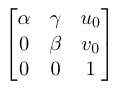

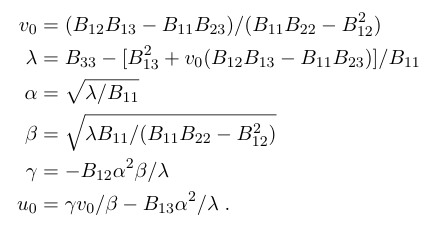

Once we have estimate of $\mathbf{K}$, we can estimate the reduced rotation and transaction matrices from each view from the homographies as follows.

\begin{eqnarray}
\mathbf{S}_i & = & 
\begin{bmatrix}
\mathbf{r}^i_1 & \mathbf{r}^i_2 & \mathbf{t}^i
\end{bmatrix} \\
& = & \lambda \mathbf{K}^{-1} \mathbf{H_i} \\
& = & \lambda \mathbf{K}^{-1}
\begin{bmatrix}
\mathbf{h}^i_1 & \mathbf{h}^i_2 & \mathbf{h}^i_3
\end{bmatrix} 
\end{eqnarray}

where $\lambda = 1/||\mathbf{K}^{-1} \mathbf{h}^i_1||$

# 2. Non-linear Refinement

(see Zhang's paper)

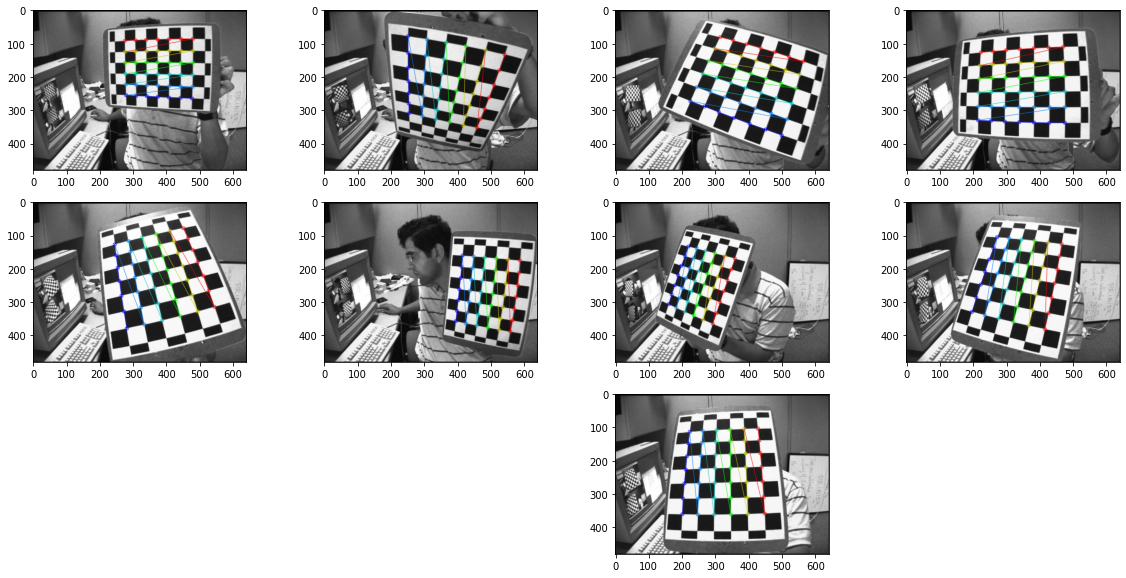

In [ ]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

plt.figure(figsize=(20,10))
images = glob.glob('/content/drive/MyDrive/Colab Notebooks/data/left*.jpg')
i = 1

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        plt.subplot(3,4,i)
        plt.imshow(img, 'gray')
    
    i = i + 1

cv2.destroyAllWindows()

# Calibration

Using OpenCV's calibration method. 
https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d


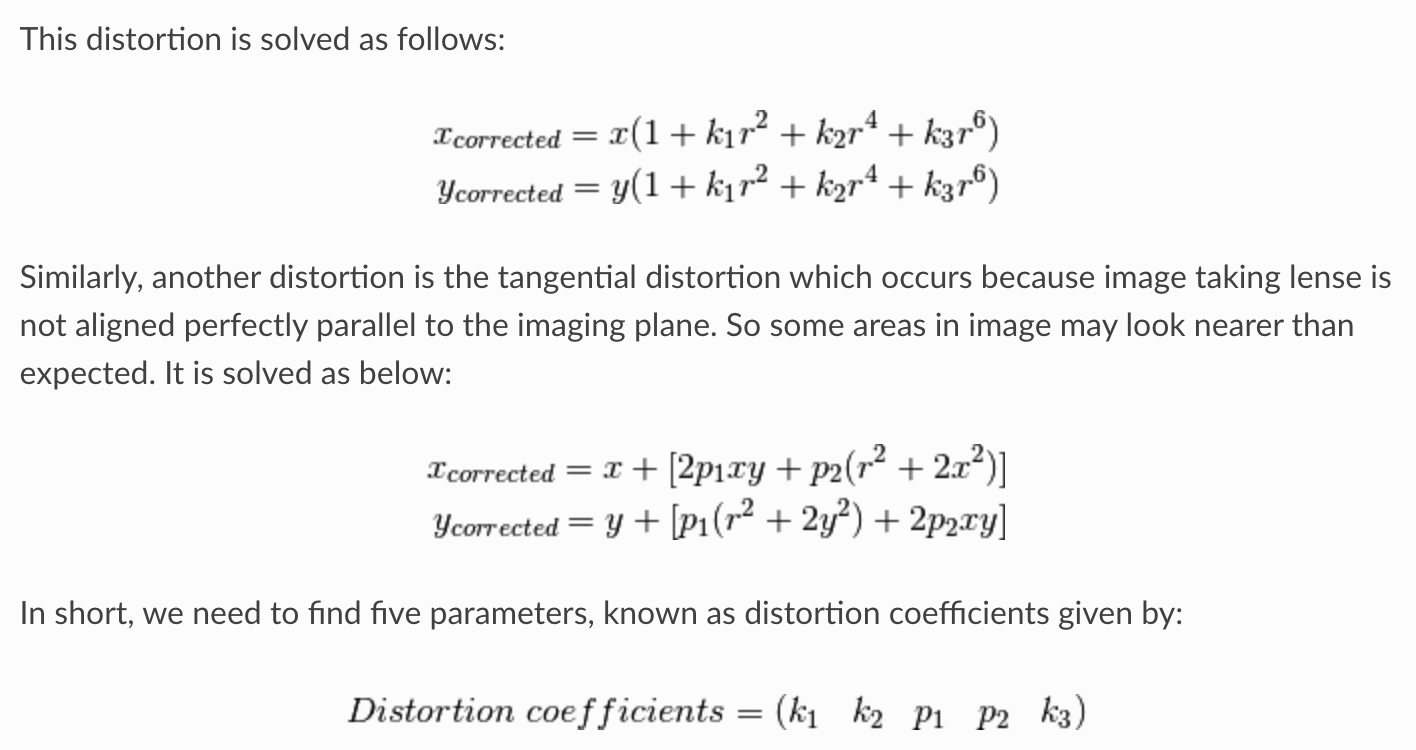

In [ ]:
from scipy.spatial.transform import Rotation 

ret, K, distortion, rvecs, T = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print('Fit error: {:0.3f}'.format(ret))
print('\nK=\n{}'.format(K))
print('\ndistortion coefficients (k1, k2, p1, p2, k3)=\n{}'.format(distortion))
# rvecs - Rotation Vector (axis of rotation -- norm is the angle of rotation)
R = Rotation.from_rotvec(np.array(rvecs).squeeze()).as_matrix()
print('\nR=\n{}'.format(R))
print('\nT=\n{}'.format(T))

Fit error: 0.156

K=
[[534.21   0.   341.94]
 [  0.   534.34 234.21]
 [  0.     0.     1.  ]]

distortion coefficients (k1, k2, p1, p2, k3)=
[[-0.3   0.15  0.    0.   -0.03]]

R=
[[[-0.96 -0.01  0.27]
  [-0.04 -0.99 -0.16]
  [ 0.27 -0.17  0.95]]

 [[ 0.09  0.98  0.2 ]
  [-0.75  0.2  -0.63]
  [-0.65 -0.09  0.75]]

 [[-0.92  0.37  0.13]
  [-0.32 -0.9   0.3 ]
  [ 0.23  0.24  0.94]]

 [[-0.97  0.01  0.24]
  [ 0.02 -0.99  0.11]
  [ 0.24  0.11  0.96]]

 [[-0.19  0.97  0.14]
  [-0.86 -0.24  0.44]
  [ 0.46 -0.03  0.89]]

 [[ 0.09  0.9   0.43]
  [-0.99  0.12 -0.04]
  [-0.08 -0.43  0.9 ]]

 [[ 0.32  0.9   0.29]
  [-0.95  0.29  0.15]
  [ 0.05 -0.32  0.95]]

 [[ 0.24  0.95  0.2 ]
  [-0.92  0.16  0.37]
  [ 0.32 -0.27  0.91]]

 [[-0.01  1.    0.07]
  [-0.93 -0.03  0.37]
  [ 0.37 -0.06  0.93]]]

T=
[array([[ 3.79],
       [ 0.86],
       [14.86]]), array([[-2.13],
       [ 1.82],
       [12.81]]), array([[3.03],
       [2.72],
       [9.91]]), array([[ 2.81],
       [ 2.2 ],
       [10.97]]), array([

# Undistortion

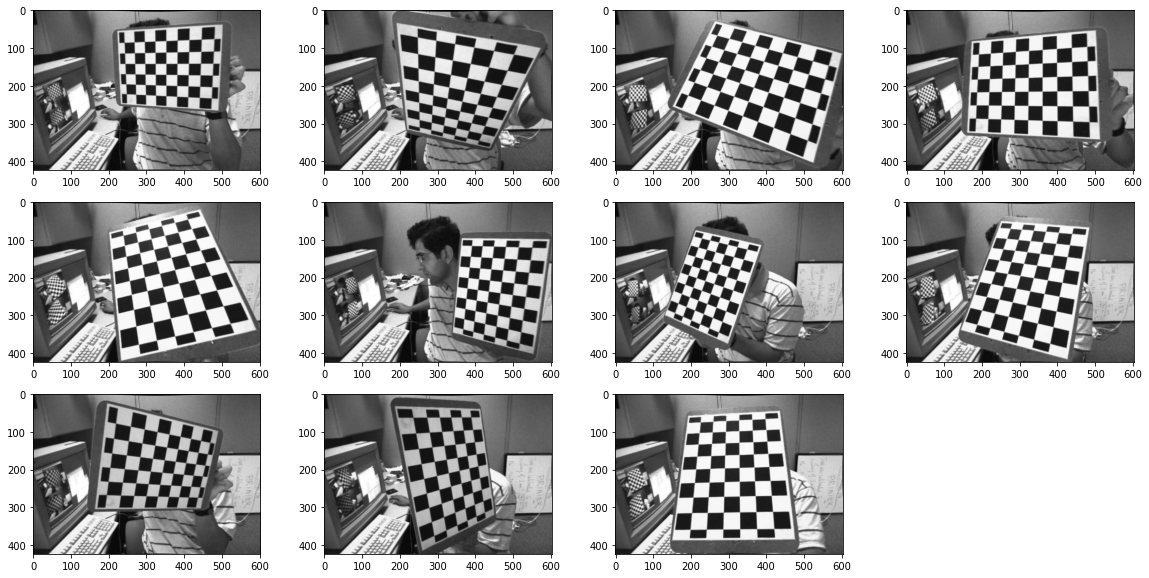

In [ ]:
plt.figure(figsize=(20,10))
i = 1
for fname in images:
    img = cv2.imread(fname)
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    plt.subplot(3,4,i)
    plt.imshow(dst, 'gray')
    i = i + 1


# Re-projection Error

In [ ]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], T[i], K, distortion)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("total error: {:0.3f} pixels".format(mean_error/len(objpoints)))

total error: 0.024 pixels


# Mixed Reality

In [ ]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(0, 0, 255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(255,0,0),3)

    return img


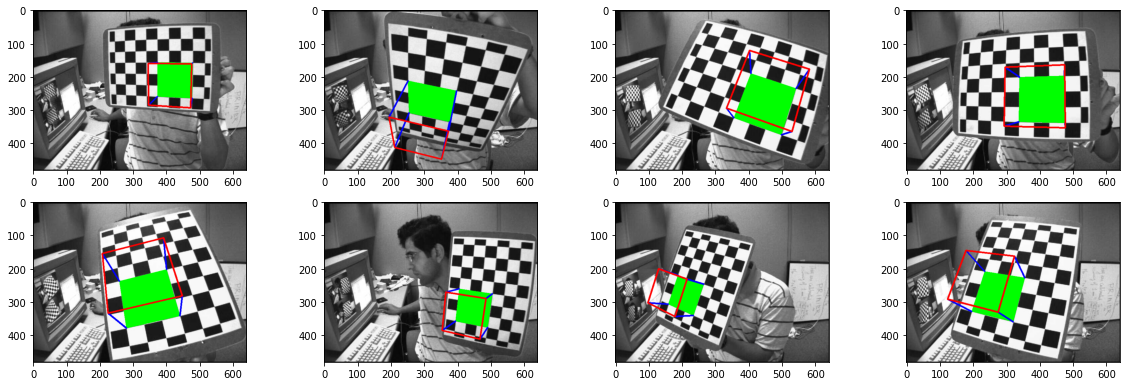

In [ ]:
plt.figure(figsize=(20,10))

for i in range (8) :
    img = cv2.imread(images[i])
    h,  w = img.shape[:2]
    axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                       [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])
    # project 3D points to image plane
    imgpts, jacobian = cv2.projectPoints(axis, rvecs[i], T[i], K, distortion)
    plt.subplot(3,4,i+1)
    img = draw(img, corners2, imgpts)
    plt.imshow(img, 'gray')
  

cv2.destroyAllWindows()
